# Coursework for MRI reconstruction (Autumn 2019)

In this tutorial, we provide the data loader to read and process the MRI data in order to ease the difficulty of training your network. By providing this, we hope you focus more on methodology development. Please feel free to change it to suit what you need.

In [1]:
import h5py, os
from functions import transforms as T
from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
import numpy as np
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

In [3]:
class MRIDataset(DataLoader):
    def __init__(self, data_list, acceleration, center_fraction, use_seed):
        self.data_list = data_list
        self.acceleration = acceleration
        self.center_fraction = center_fraction
        self.use_seed = use_seed

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]

        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction, self.use_seed)

In [4]:
def get_epoch_batch(subject_id, acc, center_fract, use_seed=True):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name, slice = subject_id  
    
    with h5py.File(rawdata_name, 'r') as data:
        rawdata = data['kspace'][slice]
                      
    slice_kspace = T.to_tensor(rawdata).unsqueeze(0)
    S, Ny, Nx, ps = slice_kspace.shape

    # apply random mask
    shape = np.array(slice_kspace.shape)
    mask_func = MaskFunc(center_fractions=[center_fract], accelerations=[acc])
    seed = None if not use_seed else tuple(map(ord, fname))
    mask = mask_func(shape, seed)
      
    # undersample
    masked_kspace = torch.where(mask == 0, torch.Tensor([0]), slice_kspace)
    masks = mask.repeat(S, Ny, 1, ps)

    img_gt, img_und = T.ifft2(slice_kspace), T.ifft2(masked_kspace)
    
    
    # perform data normalization which is important for network to learn useful features
    # during inference there is no ground truth image so use the zero-filled recon to normalize
    norm = T.complex_abs(img_und).max()
    if norm < 1e-6: norm = 1e-6
    
    # normalized data
    img_gt, img_und, rawdata_und = img_gt/norm, img_und/norm, masked_kspace/norm
    
#    img_gt = T.center_crop(T.complex_abs(img_gt), [320, 320]).unsqueeze(1)
#    img_und = T.center_crop(T.complex_abs(img_und), [320, 320]).unsqueeze(1)
#     rawdata_und = T.center_crop(T.complex_abs(rawdata_und), [320, 320]).unsqueeze(1)
#     norm = T.center_crop(T.complex_abs(norm), [320, 320]).unsqueeze(1)
#     masks.T.center_crop(T.complex_abs(masks), [320, 320]).unsqueeze(1)    

    img_gt = T.center_crop(T.complex_abs(img_gt), [320, 320])
    img_und = T.center_crop(T.complex_abs(img_und), [320, 320])
        
    return img_gt.squeeze(0), img_und.squeeze(0)


In [5]:
def load_data_path(train_data_path, val_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_and_val = ['train', 'val']
    data_path = [train_data_path, val_data_path]
      
    for i in range(len(data_path)):

        data_list[train_and_val[i]] = []
        
        which_data_path = data_path[i]
    
        for fname in sorted(os.listdir(which_data_path)):
            
            subject_data_path = os.path.join(which_data_path, fname)
                     
            if not os.path.isfile(subject_data_path): continue 
            
            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace'].shape[0]
                
            # the first 5 slices are mostly noise so it is better to exlude them
            data_list[train_and_val[i]] += [(fname, subject_data_path, slice) for slice in range(5, num_slice)]
    
    return data_list    

In [6]:
class AlexNet(nn.Module):

    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1), #320/320
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), #320/320
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(128 ,256, kernel_size=3, padding=1),  # 320/320
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1), #320/320
            nn.Dropout2d(),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),  # 320/320
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),  # 320/320
            
            
        )

    def forward(self, x):
        x = self.features(x)
        #x = nn.functional.sigmoid(x)
        #x = x * 255
        #x = x.type(torch.cuda.int32)
        return x

In [7]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [8]:
class baseBlock(torch.nn.Module):
    expansion = 1
    def __init__(self,input_planes,planes,stride=1,dim_change=None):
        super(baseBlock,self).__init__()
        #declare convolutional layers with batch norms
        self.conv1 = torch.nn.Conv2d(input_planes,planes,stride=stride,kernel_size=3,padding=1)
        self.bn1   = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes,planes,stride=1,kernel_size=3,padding=1)
        self.bn2   = torch.nn.BatchNorm2d(planes)
        self.dim_change = dim_change
    def forward(self,x):
        #Save the residue
        res = x
        #output = F.relu(self.conv1(x))
        output = F.relu(self.bn1(self.conv1(x)))
        output = self.bn2(self.conv2(output))
        #output = self.conv2(output)
        if self.dim_change is not None:
            res = self.dim_change(res)
        
        output += res
        output = F.relu(output)

        return output

class bottleNeck(torch.nn.Module):
    expansion = 4
    def __init__(self,input_planes,planes,stride=1,dim_change=None):
        super(bottleNeck,self).__init__()

        self.conv1 = torch.nn.Conv2d(input_planes,planes,kernel_size=1,stride=1)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes,planes,kernel_size=3,stride=stride,padding=1)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.conv3 = torch.nn.Conv2d(planes,planes*self.expansion,kernel_size=1)
        self.bn3 = torch.nn.BatchNorm2d(planes*self.expansion)
        self.dim_change = dim_change
    
    def forward(self,x):
        res = x
        
        output = F.relu(self.bn1(self.conv1(x)))
        output = F.relu(self.bn2(self.conv2(output)))
        output = self.bn3(self.conv3(output))

        if self.dim_change is not None:
            res = self.dim_change(res)
        
        output += res
        output = F.relu(output)
        return output

class ResNet(torch.nn.Module):
    def __init__(self,block,num_layers,classes=10):
        super(ResNet,self).__init__()
        #according to research paper:
        self.input_planes = 64
        self.conv1 = torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1)
        #self.bn1   = torch.nn.BatchNorm2d(64)
        self.layer1 = self._layer(block,64,num_layers[0],stride=1)
        self.layer2 = self._layer(block,64,num_layers[1],stride=1)
        self.layer3 = self._layer(block,64,num_layers[2],stride=1)
        self.layer4 = self._layer(block,64,num_layers[3],stride=1)
        self.layer5 = self._layer(block,64,num_layers[3],stride=1)
        self.layer6 = self._layer(block,64,num_layers[3],stride=1)
        self.layer7 = self._layer(block,64,num_layers[3],stride=1)
        self.layer8 = self._layer(block,64,num_layers[2],stride=1)
        self.layer9 = self._layer(block,64,num_layers[3],stride=1)
        self.layer10 = self._layer(block,64,num_layers[3],stride=1)
        self.layer11 = self._layer(block,64,num_layers[3],stride=1)
        self.layer12 = self._layer(block,64,num_layers[3],stride=1)
        
        #self.conv3 = torch.nn.Conv2d(64,64,kernel_size=3,stride=1, padding=1)
        #self.conv4 = torch.nn.Conv2d(64,64,kernel_size=3,stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(64,1,kernel_size=3,stride=1, padding=1)
        
    
    def _layer(self,block,planes,num_layers,stride=1):
        dim_change = None
        if stride!=1 or planes != self.input_planes*block.expansion:
            dim_change = torch.nn.Sequential(torch.nn.Conv2d(self.input_planes,planes*block.expansion,kernel_size=1,stride=stride),
                                             torch.nn.BatchNorm2d(planes*block.expansion))
        netLayers =[]
        netLayers.append(block(self.input_planes,planes,stride=stride,dim_change=dim_change))
        self.input_planes = planes * block.expansion
        for i in range(1,num_layers):
            netLayers.append(block(self.input_planes,planes))
            self.input_planes = planes * block.expansion
        
        return torch.nn.Sequential(*netLayers)

    def forward(self,x):
        #x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv1(x))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        #x = self.conv3(x)
        #x = self.conv4(x)
        x = self.conv3(x)

        return x

In [9]:
from skimage.measure import compare_ssim 
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return compare_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )

In [ ]:


if __name__ == '__main__':
    
    data_path_train = '/data/local/NC2019MRI/train'
    data_path_val = '/data/local/NC2019MRI/train'
    data_list = load_data_path(data_path_train, data_path_val) # first load all file names, paths and slices.
    
    acc = 4
    cen_fract = 0.08
    seed = False # random masks for each slice 
    num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    
    lr = 5e-3
    
    network = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
    network.to('cuda:0') #move the model on the GPU
    mse_loss = nn.L1Loss().to('cuda:0')
    
    optimizer = optim.Adam(network.parameters(), lr=lr)
    fixed_train_set = []
    for val in data_list['train']:
        if val[2] > 5:
            fixed_train_set.append(val)
    #create data loader for training set. It applies same to validation set as well
    train_dataset = MRIDataset(fixed_train_set, acceleration=acc, center_fraction=cen_fract, use_seed=seed)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=num_workers) 
    
    losses=[]
    mean_loss_list = []
    
    for epoch in range(10):
        i = 0
        for iteration, sample in enumerate(train_loader):
            i += 1
            img_gt, img_und = sample
        
            img_gt = img_gt.unsqueeze(1).to('cuda:0')
            img_und = img_und.unsqueeze(1).to('cuda:0')

            output = network(img_und)       #feedforward
            #output = output.squeeze(1).cpu().detach().numpy()

            loss = mse_loss(output, img_gt)
            #loss = torch.tensor(ssim(img_gt, output)).to('cuda:0')
            #print(loss.item())
            optimizer.zero_grad()       #set current gradients to 0
            loss.backward()      #backpropagate
            optimizer.step()     #update the weights
            mean_loss_list.append(loss.item())
            if i%5 == 0:
                print(np.round(np.mean(mean_loss_list), decimals = 5), "  ", i, "  ", epoch+1)
                mean_loss_list = []
            losses.append(loss.item() * img_gt.size(0))
        #epoch_loss = running_loss / len(train_loader['train'])
        #losses.append(epoch_loss)
        #plt.plot(np.array(loss_values), 'r')
        
#         stack different slices into a volume for visualisation
#         A = masks[...,0].squeeze()
#         B = torch.log(T.complex_abs(rawdata_und) + 1e-9).squeeze()
#         C = T.complex_abs(img_und).squeeze()
#         D = T.complex_abs(img_gt).squeeze()
#         all_imgs = torch.stack([A,B,C,D], dim=0)

#         # from left to right: mask, masked kspace, undersampled image, ground truth
#         show_slices(all_imgs, [0, 1, 2, 3], cmap='gray')
#         plt.pause(1)

#         if iteration >= 0: break  # show 4 random slices
        

3.74952    5    1
1.23724    10    1
0.55153    15    1
0.31653    20    1
0.30987    25    1
0.30328    30    1
0.3249    35    1
0.35459    40    1
0.22235    45    1
0.1535    50    1
0.20223    55    1
0.18435    60    1
0.16446    65    1
0.10188    70    1
0.11124    75    1
0.15028    80    1
0.10541    85    1
0.10495    90    1
0.10644    95    1
0.10574    100    1
0.11157    105    1
0.10308    110    1
0.08679    115    1
0.10191    120    1
0.10104    125    1
0.09076    130    1
0.08322    135    1
0.08121    140    1
0.09158    145    1
0.0901    150    1
0.09547    155    1
0.10949    160    1
0.08301    165    1
0.08641    170    1
0.07293    175    1
0.05919    180    1
0.08815    185    1
0.08861    190    1
0.07224    195    1
0.07542    200    1
0.08733    205    1
0.10221    210    1
0.10013    215    1
0.08132    220    1
0.08306    225    1
0.08127    230    1
0.09743    235    1
0.0869    240    1
0.0718    245    1
0.10971    250    1
0.21785    255    1
0.128

In [11]:
#bs-batch size, ep - epoch, lr - learning rate, bd - block dimensions
torch.save(network.state_dict(), "/home/students/jaf669/work/GroupProject/bs2_ep5_lr5e-3_bd3-4-6-3_second_run.pt")


In [1]:
import matplotlib.pyplot as plt
plt.plot(losses[200::20])
plt.show()

NameError: name 'losses' is not defined

In [11]:
gt, image = train_dataset[2]
image = image.unsqueeze(0).to('cuda:0')
image = image.unsqueeze(0)
print(image.shape)
#gt = gt.unsqueeze(0).to('cuda:0')
gt = gt.unsqueeze(0).numpy()
output = network(image)
output = output.squeeze(1).cpu().detach().numpy()
loss = torch.tensor(ssim(gt, output))
loss2 = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
print(loss.item())
print(loss2.item())
#loss2 = mse_loss(output, gt)
len(train_dataset)

torch.Size([1, 1, 320, 320])
0.609542191028595
0.5472149848937988


/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


2064

In [12]:
e = []
a=[]
b=[]
i = 0
for i in range(0,len(train_dataset)):
    gt, image = train_dataset[i]
    image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    #gt = gt.unsqueeze(0).to('cuda:0')
    gt = gt.unsqueeze(0).numpy()
    output = network(image)
    output = output.squeeze(1).cpu().detach().numpy()
    loss = torch.tensor(ssim(gt, output))
    loss2 = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    e.append(loss.item()-loss2.item())
    a.append(loss.item())

    if loss.item()-loss2.item() < 0:
        i+=1
print(np.nanmean(e))
print(np.nanmean(a))

/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


0.02365236665851386
0.5900136828133764


In [15]:
listaaa = []
for i in e:
    if i < 0:
        listaaa.append(i)
print(np.mean(listaaa))
print(len(listaaa))

-0.015579135305995407
607


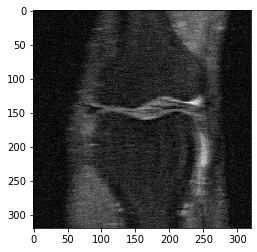

In [16]:

gt, image = train_dataset[70]
image = image.unsqueeze(0).to('cuda:0')
image = image.unsqueeze(0)
#gt = gt.unsqueeze(0).to('cuda:0')
gt = gt.numpy()
#model.to("cuda:0")
output = network(image)
output = output.squeeze(1).cpu().detach().numpy()
net_out = output.squeeze(0)
plt.imshow(image.squeeze(0).squeeze(0).cpu(), cmap='gray')



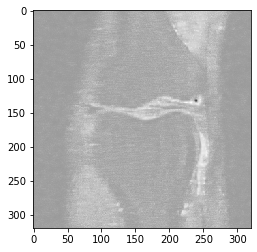

In [17]:
plt.imshow(net_out, cmap='gray')

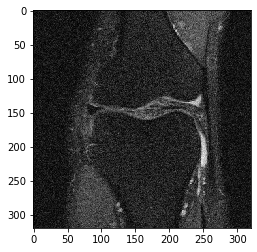

In [18]:
plt.imshow(gt, cmap='gray')

In [21]:
gt, image = train_dataset[3]
image = image.unsqueeze(0).to('cuda:0')
image = image.unsqueeze(0)
gt = gt.unsqueeze(0).to('cuda:0')
gt = gt.unsqueeze(0)
output = network(image)
loss = mse_loss(output, gt)
loss2 = mse_loss(image, gt)
print(loss.item())
print(loss2.item())

0.0339510552585125
0.029671862721443176


In [45]:
model = ResNet(baseBlock, [3,4,6,3])
model.load_state_dict(torch.load("/home/students/jaf669/work/GroupProject/bs2_ep5_lr5e-3_bd3-4-6-3.pt"))
print(model.conv1.weight.data.numpy() == network.cpu().conv1.weight.data.numpy())
#print(network.conv1.weight.data.numpy())

[[[[ True  True  True]
   [ True  True  True]
   [ True  True  True]]]


 [[[ True  True  True]
   [ True  True  True]
   [ True  True  True]]]


 [[[ True  True  True]
   [ True  True  True]
   [ True  True  True]]]


 [[[ True  True  True]
   [ True  True  True]
   [ True  True  True]]]


 [[[ True  True  True]
   [ True  True  True]
   [ True  True  True]]]


 [[[ True  True  True]
   [ True  True  True]
   [ True  True  True]]]


 [[[ True  True  True]
   [ True  True  True]
   [ True  True  True]]]


 [[[ True  True  True]
   [ True  True  True]
   [ True  True  True]]]


 [[[ True  True  True]
   [ True  True  True]
   [ True  True  True]]]


 [[[ True  True  True]
   [ True  True  True]
   [ True  True  True]]]


 [[[ True  True  True]
   [ True  True  True]
   [ True  True  True]]]


 [[[ True  True  True]
   [ True  True  True]
   [ True  True  True]]]


 [[[ True  True  True]
   [ True  True  True]
   [ True  True  True]]]


 [[[ True  True  True]
   [ True  True  True]
   [ 

In [49]:
e = []
a=[]
b=[]
i = 0
model.to("cuda:0")
for i in range(0,3):
    gt, image = train_dataset[i]
    image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    #gt = gt.unsqueeze(0).to('cuda:0')
    gt = gt.unsqueeze(0).numpy()
    output = model(image)
    output = output.squeeze(1).cpu().detach().numpy()
    loss = torch.tensor(ssim(gt, output))
    loss2 = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    e.append(loss.item()-loss2.item())
    a.append(loss.item())

    if loss.item()-loss2.item() < 0:
        i+=1
print(np.nanmean(e))
print(np.nanmean(a))

/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


0.05812176068623861
0.570702334245046


In [50]:
e = []
a=[]
b=[]
i = 0
for i in range(0,3):
    gt, image = train_dataset[i]
    image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    #gt = gt.unsqueeze(0).to('cuda:0')
    gt = gt.unsqueeze(0).numpy()
    network.to("cuda:0")
    output = network(image)
    output = output.squeeze(1).cpu().detach().numpy()
    loss = torch.tensor(ssim(gt, output))
    loss2 = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    e.append(loss.item()-loss2.item())
    a.append(loss.item())

    if loss.item()-loss2.item() < 0:
        i+=1
print(np.nanmean(e))
print(np.nanmean(a))

/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


0.06027336915334066
0.577251931031545
